## KOmbinovani model (Model 1. Resnet 18), manji dataset


In [5]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
casting_data_path = '../data_set_with_generated/casting_data'
casting_data_train_defective_path = os.path.join(casting_data_path, 'train/def_front')
casting_data_train_ok_path = os.path.join(casting_data_path, 'train/ok_front')
casting_data_test_defective_path = os.path.join(casting_data_path, 'test/def_front')
casting_data_test_ok_path = os.path.join(casting_data_path, 'test/ok_front')


### Definišemo transformacije za pripremu podataka

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Promenite veličinu slike na 128x128 piksela
    transforms.ToTensor(),  # Pretvaramo slike u tenzore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacija
])

### Kreiramo ImageFolder objekte za treniranje i testiranje

In [8]:
train_dataset = ImageFolder(root=os.path.join(casting_data_path, 'train'), transform=transform)
test_dataset = ImageFolder(root=os.path.join(casting_data_path, 'test'), transform=transform)

### Kreiramo DataLoader objekte za obuku i testiranje


In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [10]:
# Kreiramo model koristeći pretrenirani ResNet18 model
model = models.resnet18(pretrained=True)

/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Prilagodimo poslednji sloj za našu klasifikaciju
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 klase: 'ok' i 'defect'

In [12]:
# Proveravamo dostupnost CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Definišemo gresku i optimizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# Funkcija za obuku modela
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    print('Training complete')

In [15]:
# Model train
train_model(model, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss: 0.1022
Epoch 2/10, Loss: 0.0239
Epoch 3/10, Loss: 0.0120
Epoch 4/10, Loss: 0.0099
Epoch 5/10, Loss: 0.0073
Epoch 6/10, Loss: 0.0057
Epoch 7/10, Loss: 0.0046
Epoch 8/10, Loss: 0.0050
Epoch 9/10, Loss: 0.0037
Epoch 10/10, Loss: 0.0038
Training complete


In [16]:
# Funkcija za evaluaciju modela
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Evaluacija modela
evaluate_model(model, test_loader, device)

Accuracy: 99.72%


In [17]:
# Prikaz nekih slika iz testnog skupa sa predikcijama
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    fig = plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        ax = plt.subplot(2, 4, idx+1)
        img = transforms.ToPILImage()(images[idx].cpu())
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}')
        ax.axis('off')
    plt.show()

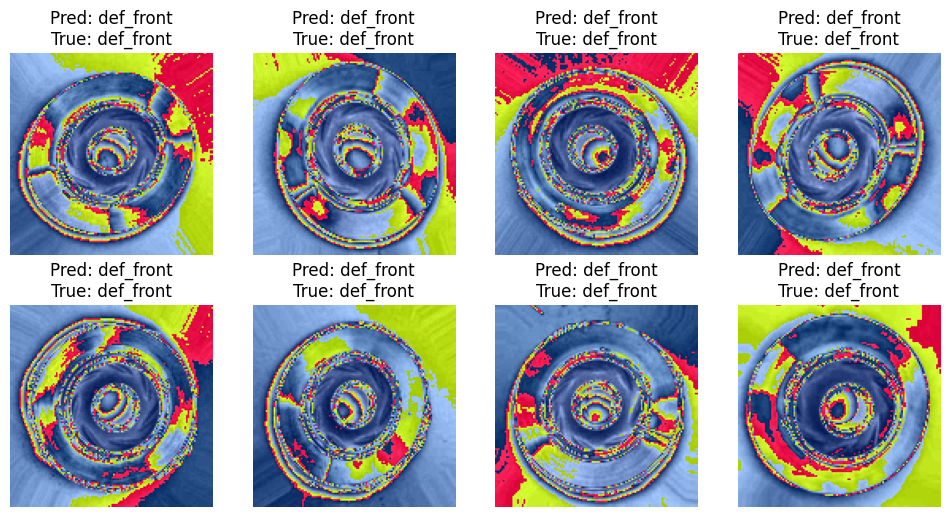

In [18]:
# Prikaz predikcija
class_names = train_dataset.classes
show_predictions(model, test_loader, class_names, device)